# Exploratory Data Analysis Notebook

### Description

This is the April 2025 podcast listening time podcast prediction competition.

The goal is to analyze and predict the average listening duration of podcast episodes based on various features.

### Files
1. train.csv
2. test.csv
3. sample_submission.csv

### Evaluation

The evaluation metric is the RMSE.

Submission File
For each id in the test set, you must predict the number of minutes listened. The file should contain a header and have the following format:

- id,Listening_Time_minutes
- 26570,0.2
- 26571,0.1
- 26572,0.9
- etc.

## Package Importing

In [2]:
# general python libraries
import time
import sys
import datetime
import math
import numpy as np

# dataframe and data manipulation library
import pandas as pd

# visualisation and EDA libraries
import matplotlib.pyplot as  plt
import ydata_profiling
import seaborn as sns

## Data Importing

In [3]:
folder_path = '../data/raw'
train_data = pd.read_csv(f'{folder_path}/train.csv')
test_data = pd.read_csv(f'{folder_path}/test.csv')
sample = pd.read_csv(f'{folder_path}/sample_submission.csv')

## Dataset Summaries and Heads

In [4]:
print("Number of rows in train data:    \t",train_data.shape[0])
print("Number of columns in train data: \t",train_data.shape[1])
print("\nNumber of rows in test data:     \t",test_data.shape[0])
print("Number of columns in test data:  \t",test_data.shape[1])
print("\nNumber of rows in sample data:   \t",sample.shape[0])
print("Number of column in sample data: \t",sample.shape[1])

Number of rows in train data:    	 750000
Number of columns in train data: 	 12

Number of rows in test data:     	 250000
Number of columns in test data:  	 11

Number of rows in sample data:   	 250000
Number of column in sample data: 	 2


In [5]:
# check datatypes of columns
print(train_data.dtypes.value_counts())

object     6
float64    5
int64      1
Name: count, dtype: int64


non-numeric column categories based on data from  750000 rows


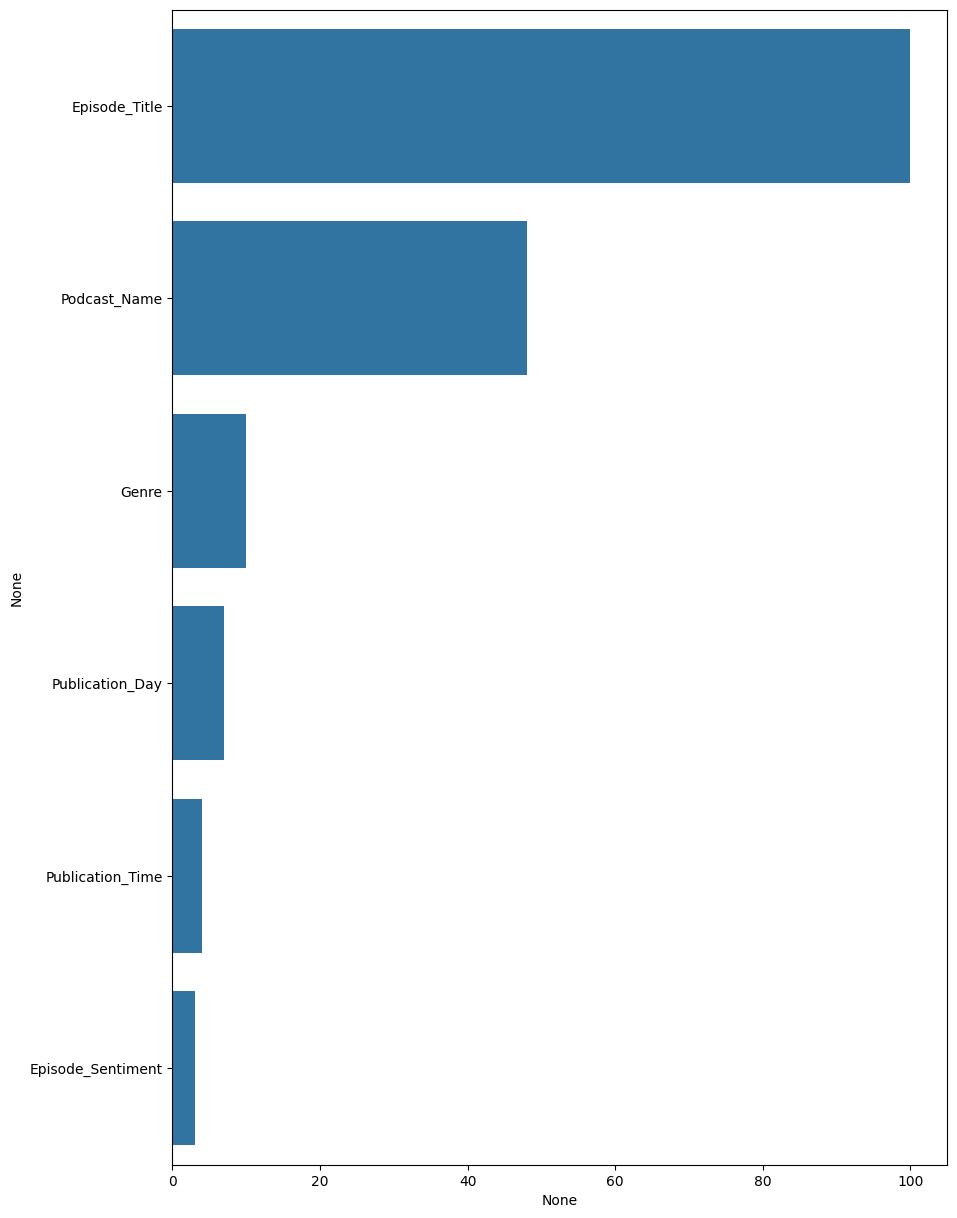

In [6]:
# save names of categorical columns
numeric_cols = train_data.dtypes[train_data.dtypes != "object"].index
cat_cols = train_data.dtypes[train_data.dtypes == "object"].index

# view cardinalitites of categorical columns
print('non-numeric column categories based on data from ', train_data.shape[0],'rows')

cat_name = []
nunique_vals = []
for i in cat_cols:
    cat_name.append(i)
    nunique_vals.append(train_data.loc[:,i].nunique())

cat_counts = pd.Series(data=nunique_vals,index=cat_name).sort_values(ascending = False)

fig = plt.figure(figsize=(10,15))
ax = sns.barplot(y = cat_counts.index, x = cat_counts, orient='h')

In [7]:
train_data.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [8]:
test_data.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


In [9]:
sample.head()

,id,Listening_Time_minutes
0,750000,45.437
1,750001,45.437
2,750002,45.437
3,750003,45.437
4,750004,45.437


In [10]:
# checking missing data
total = train_data.isnull().sum().sort_values(ascending = False)
percent = (train_data.isnull().sum()/train_data.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data

,Total,Percent
Guest_Popularity_percentage,146030,19.470667
Episode_Length_minutes,87093,11.612400
Number_of_Ads,1,0.000133
id,0,0.000000
Podcast_Name,0,0.000000
Episode_Title,0,0.000000
Genre,0,0.000000
Host_Popularity_percentage,0,0.000000
Publication_Day,0,0.000000
Publication_Time,0,0.000000


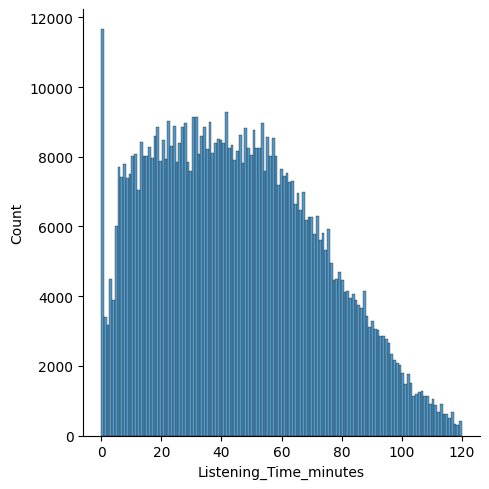

In [11]:
# checking target variable percentage
sns.displot(x="Listening_Time_minutes", data=train_data)
#sns.countplot(x="failure", data=test_data)
#sns.countplot(x="failure", data=sample)

# this is a class imbalance problem

## Distributional drift and comparisons

In [12]:
train_data.columns

Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment', 'Listening_Time_minutes'],
      dtype='object')

each of the products could have very different behaviours and be from different populations. And so it may make sense to look at each on of these individually

## Static Profiling

In [13]:
# sample data if required if reports too big
train_sample = train_data.sample(10000)

# drop id column
train_sample.drop('id',axis = 1, inplace=True)

# drop index or else that will also be profiled
train_sample.reset_index(drop=True, inplace=True)

In [14]:
# create minimal report in reports
minimal_report = train_data.profile_report(title="Minimal Report",minimal=True)
minimal_report.to_file("../reports/pp_eda_minimal.html")
#minimal_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 23.96it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
# set of parameters to create customer report
train_data.profile_report(
    title="Custom Report",
    # create missing/null value diagrams
    # disable if no missing values
    missing_diagrams={
        "heatmap": True,
        "dendrogram": True,
        "bar": True,
        "matrix":True
    # create all correlation plots
    # the correlations and interactions come together
    # the correlations section dictates which corrs will be run
    # the interactions dicatates which variables
    },correlations={
        # strength and directional
        # continuous vars, linear, sensitive to outliers, normal dist
        "pearson": {"calculate": True},
        # strength and directional
        # categorical or quant, linear, no outliers
        "spearman": {"calculate": False},
        # 0-1
        # dependence of 2 vars.
        "kendall": {"calculate": True},
        # no direction, categorical, ordinal, interval
        # non-linear dependency
        # computationally expensive
        "phi_k": {"calculate": True}, # this one is one of the most intensive ones
        # compares 2 categorical vars
        # based on chi-squared test stat
        # sensitive to outlies
        "cramers": {"calculate": True}
    },interactions = {
        # this generates 2d scatter, this will cause crash if too many variables
        "continuous": False,
        # comment continouous out and put in 
        # target var to see scatter between
        # only these values and all other
        # values
        "targets": ['Listening_Time_minutes']
    },html = {
        "style": {"theme":"flatly"}
    }
    
    
).to_file("../reports/pp_eda_custom.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:01<00:00,  7.93it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Exception ignored in: <function ResourceTracker.__del__ at 0x10666f7e0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1076c77e0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/m

## Data Cleaning

Creation of data cleaning function to;
- Impute NULL Values
- Parse Multi-part string columns
- Drop columns
- Encode categorical variables
- Normalise or scale columns

In [15]:
def Preprocessing(df):
    
    df = pd.get_dummies(df) # convert all categorical variables to dummy variables
    
    df = df.dropna(
        # axis = 1 # default both axes, comment out for only 1 axis
    ) # remvoe all na rows or columns
    
    return df

train_data_cleaned = Preprocessing(train_data)

print("missing values present:",train_data_cleaned.isna().sum().sum())
print("categorical columns present:",train_data_cleaned.dtypes[train_data_cleaned.dtypes == "object"].count())



missing values present: 0
categorical columns present: 0


## Model fitting

### Train Test Split

Splitting data into groupings for model fitting

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data_cleaned.drop(['id','failure'], axis = 1), # X data excluding target variable and any irrelevant id columns
    train_data_cleaned.loc[:,'failure'],
    test_size = 0.2, # 0.2 is a good accepted starting point, with larger data this number can be decreased
    random_state = 42, # random seed, default 42
    shuffle = True # default true, check whether there is population drift over time in default order
)

print("Shape of X_train data:    \t",X_train.shape)
print("Shape of X_test data:    \t",X_test.shape)
print("Shape of y_train data:    \t",y_train.shape)
print("Shape of y_test data:    \t",y_test.shape)

Shape of X_train data:    	 (9746, 31)
Shape of X_test data:    	 (2437, 31)
Shape of y_train data:    	 (9746,)
Shape of y_test data:    	 (2437,)


### Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression
# help(LinearRegression)

In [18]:
# initialise new linear regression object model
model = LinearRegression()

In [19]:
# Fir regression model
model.fit(X_train, y_train)

LinearRegression()

In [20]:
# predict values on test set
test_preds = model.predict(X_test)

In [ ]:
test_residuals = y_test - test_preds

# ideally this is normal
sns.scatterplot(x=y_test,y=test_residuals)
plt.axhline(y=0,color='r',ls='--')

In [ ]:
# these coeffients will be in different units
model.coef_

In [ ]:
from joblib import dump, load
dump(model,'../models/linear_regression_model.joblib')